In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np

# load administrative boundaries and transform to 4326

world_shp= gpd.read_file(r'data\merge._freq-point.shp')
df_weight= pd.read_excel(r'data\dayu.xlsx')




11
1.6507462686567165
1.0


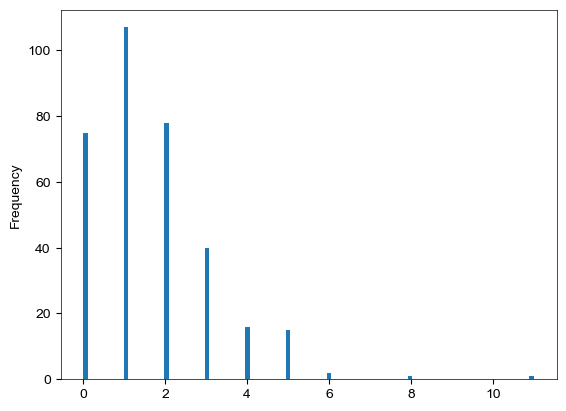

In [24]:


df_weight['10yr'].plot.hist(bins=100)
print(df_weight['10yr'].max())
print(df_weight['10yr'].mean())
print(df_weight['10yr'].median())




In [36]:

def percentile_cal(mode, data, column='10yr', values=None):
    """
    综合分位数工具函数。
    - mode: 'value_by_percentile' 或 'percentile_by_value'
    - data: DataFrame
    - column: 列名
    - values: 
        - 若 mode='value_by_percentile'，则为分位数list（如[90,80,70]）
        - 若 mode='percentile_by_value'，则为单个数值或数值list
    返回：
        - mode='value_by_percentile'：返回该列对应分位数的数值list
        - mode='percentile_by_value'：返回该数值在该列中的分位数（0-100），若输入list则返回list
    """
    arr = np.sort(data[column].values)
    if mode == 'value_by_percentile':
        result = []
        for p in values:
            val = np.percentile(arr, p)
            result.append(val)
        return result
    elif mode == 'percentile_by_value':
        if isinstance(values, (list, np.ndarray, pd.Series)):
            return [((arr <= v).sum() / len(arr) * 100) for v in values]
        else:
            return (arr <= values).sum() / len(arr) * 100
    else:
        raise ValueError("mode must be 'value_by_percentile' or 'percentile_by_value'")

percentile_cal('value_by_percentile', df_weight, column='10yr', values=[90,80,70])


[4.0, 3.0, 2.0]

In [34]:
percentile_cal('percentile_by_value', df_weight, column='10yr', values=[4])


[94.32835820895522]

# 1、同色版本

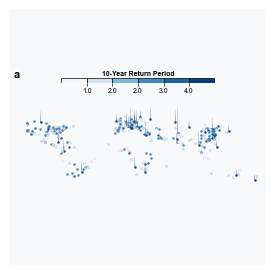

3D密度图生成完成！


In [15]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import art3d

def plot_3d_density(
    df_weight, 
    world_shp,
    base_shp=None,
    var_names=('10yr'),
    var_threshold_pcts=(5),
    *, 
    spike_mode='line'        # 'line' | 'cone' | 'pyramid'
):
    """
    目标：
    - def _stretch_xy 函数控制的是图像伸缩程度（需要大量实验测试，不同的底图有不同伸缩方式来适应）
    - def _fullwidth_axe函数控制的是数据框大小（相当于地图外侧有个数据框，它与画布的设置figsize是有所不同的）
    - 主要控制视觉效果的是CFG中的elev，azim；
    - 峰值（我这里给出了三种）
    """

    CFG = dict(
        fig_size=(65/25.4, 30/25.4),
        elev=60, azim=-90,        # ≈30°俯视、另外一个控制朝向，一般来说从南看北是这个角度。
        bg="#f7f9fb",
        border_frac=0.01,         # 地图四周小留白
        z_exag=0.75,               # 控制峰值的大小
        peak_floor=0.25,
        max_spikes=200,
        line_width=1.0,
        cmaps=(plt.cm.Blues, plt.cm.YlOrBr, plt.cm.Oranges, plt.cm.Reds),
        colorbar_percentiles=[100, 50, 30, 20, 10],  # 这里输入的是1-分位数X%，目前给的例子意思是：对应颜色棒从左到右分别是0%，50%，70%，80%，90%；
        # colorbar_labels=['90%', '80%', '70%', '60%', '50%'],
        # colorbar_thresholds=[1, 2, 3, 6, 11],  # 具体的数值切分点
        # colorbar_labels=['1', '2', '3', '6', '11'], 
        simplify_factor=0.1,
        max_base_features=800, # 简化因子       # 最大特征数
        base_simplify_factor=0.05,  # 底图简化因子
   
    )

    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "axes.linewidth": 0.5, "axes.edgecolor": "black",
    })

    # ——— 数据准备（使用city字段关联） ———
    
    # 通过city字段进行关联
    joined = world_shp.merge(
        df_weight[['city'] + list(var_names)], 
        on='city', 
        how='inner'
    )
    
    # 计算统计值（按city分组）
    stats = joined.groupby('city').agg({vn: "mean" for vn in var_names}).reset_index()
    world_plot = world_shp.merge(stats, on='city', how='left').fillna(0.0)
    if base_shp is not None:
        base_plot = base_shp.simplify(CFG["base_simplify_factor"])
        if len(base_plot) > CFG["max_base_features"]:
            base_plot['area'] = base_plot.geometry.area
            base_plot = base_plot.nlargest(CFG["max_base_features"], 'area').drop(columns=['area'])
   
    # 获取边界框
    xmin0, ymin0, xmax0, ymax0 = world_plot.total_bounds
    bx = (xmax0 - xmin0) * CFG["border_frac"]
    by = (ymax0 - ymin0) * CFG["border_frac"]
    xmin, xmax = xmin0 - bx, xmax0 + bx
    ymin, ymax = ymin0 - by, ymax0 + by
    xmid, ymid = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    xspan, yspan = (xmax-xmin), (ymax-ymin)

    figs = []

    # —— 关键：自动把 3D pane 变成"以宽度为限的正方形"，并贴到底边 —— 
    def _fullwidth_axes(fig, ax):
        fw, fh = fig.get_size_inches()         # 例如 60mm×35mm
        need_h_norm = (fw / fh)                # 让轴域的归一化高度 >= 宽度（1.0）* (fw/fh)
        h = need_h_norm * 1.02              # 略加 2% 缓冲
        bottom = 1.5 - h                       # 顶边对齐到 1.0，把轴域整体"向下拉出画布"
        ax.set_position([0.0, bottom, 1.0, h]) # → pane 会以"宽度"为限制，横向吃满 60mm

    def _stretch_xy(fig, y_scale=1.0):
        # x和y都可拉伸，y_scale控制y方向拉伸倍数（默认1.0为不变）
        fw, fh = fig.get_size_inches()
        target_aspect = fw / fh
        data_aspect   = (xspan / yspan) if yspan > 0 else 1.0
        sx = target_aspect / data_aspect
        sy = y_scale * 1.25
        def sx_fun(xx): return xmid + sx*(xx - xmid)
        def sy_fun(yy): return ymid + sy*(yy - ymid)
        return sx_fun, sy_fun, sx, sy

    # ——— 可选的体块峰（若需要） ———
    def _add_line(ax, cx, cy, H, color, lw):
        ax.plot([cx,cx],[cy,cy],[0,H], color=color, lw=lw, alpha=0.95, zorder=20)

    def _add_cone(ax, cx, cy, H, color):
        # 极简圆锥：两圈就够（轻量）
        th = np.linspace(0, 2*np.pi, 24, endpoint=False)
        r0, r1 = 0.12, 0.0
        x0, y0 = cx + r0*np.cos(th), cy + r0*np.sin(th)
        x1, y1 = cx + r1*np.cos(th), cy + r1*np.sin(th)
        faces=[]
        for j in range(len(th)):
            j2=(j+1)%len(th)
            faces.append([(x0[j],y0[j],0.0),(x0[j2],y0[j2],0.0),(x1[j2],y1[j2],H)])
            faces.append([(x0[j],y0[j],0.0),(x1[j2],y1[j2],H), (x1[j],y1[j],H)])
        ax.add_collection3d(Poly3DCollection(faces, facecolor=(*color[:3],0.96), edgecolor=None, linewidths=0.1))

    def _add_pyramid(ax, cx, cy, H, color):
        d = 0.1
        base = np.array([[cx-d,cy,0],[cx,cy+d,0],[cx+d,cy,0],[cx,cy-d,0]])
        apex = np.array([cx,cy,H])
        faces=[[base[0],base[1],apex],[base[1],base[2],apex],[base[2],base[3],apex],[base[3],base[0],apex]]
        ax.add_collection3d(Poly3DCollection(faces, facecolor=(*color[:3],0.96), edgecolor=None, linewidths=0.12))
    
    def _add_colorbar(fig, ax, colorbar_thresholds, cmap, variable_name, peak_threshold):
        """添加左下角5段colorbar，在颜色交界处显示原始数值"""
        left, bottom, width, height = 0.20, 0.85, 0.60, 0.045
        cax = fig.add_axes([left, bottom, width, height], zorder=100)
        cax.set_in_layout(False)
        cax.set_zorder(50)

        # 6段颜色：灰色(第一段) + 5段对比明显的颜色
        colors = ['whitesmoke']  # 第一段：灰色
        
        # 使用离散的颜色映射，让每段颜色对比更明显
        color_norms = [0.2, 0.45, 0.65, 0.8, 0.95]  # 5个离散的归一化值，增加对比度
        for norm in color_norms:
            colors.append(cmap(norm))
        
        # 绘制colorbar
        segment_width = 1.0 / 6
        for i in range(6):
            x_start = i * segment_width
            x_end = (i + 1) * segment_width
            cax.barh(0.5, x_end - x_start, left=x_start, height=1,
                    color=colors[i], edgecolor='black', linewidth=0.5)

        # 设置范围
        cax.set_xlim(0, 1)
        cax.set_ylim(0, 1)
        cax.set_yticks([])
        for spine in cax.spines.values():
            spine.set_visible(False)
        
        # 在颜色交界处显示原始数值 - 5个交界处对应5个数值
        tick_positions = [i * segment_width for i in range(1, 6)]  # 5个交界处位置
        # 计算原始数值 - 5个交界处的值
        tick_values = colorbar_thresholds  # 5个阈值
        tick_labels = [f'{v:.1f}' for v in tick_values]  # 保留1位小数，更精确
        
        cax.set_xticks(tick_positions)
        cax.set_xticklabels(tick_labels, fontsize=5)
        
        # 缩小tick大小
        cax.tick_params(axis='x', which='major', length=2, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1, width=0.3, label1On=False)
        
        # 添加标题
        cax.text(0.5, 1.3, variable_name, ha='center', va='bottom', 
                fontsize=5, fontweight='bold', transform=cax.transAxes)

        return cax
    

    for i,(vn,pctl) in enumerate(zip(var_names, var_threshold_pcts)):
        cmap = CFG["cmaps"][i] if i < len(CFG["cmaps"]) else plt.cm.viridis

        fig = plt.figure(figsize=CFG["fig_size"])
        ax  = fig.add_subplot(111, projection="3d")
        ax.set_axis_off()
        fig.patch.set_facecolor("white")
        ax.set_facecolor(CFG["bg"])

        # —— 横向拉伸（x 变宽，y 不变）——
        sx_fun, sy_fun, sx, sy = _stretch_xy(fig)
        xmin_s, xmax_s = sx_fun(xmin), sx_fun(xmax)
        ymin_s, ymax_s = sy_fun(ymin), sy_fun(ymax)
        xspan_s, yspan_s = (xmax_s-xmin_s), (ymax_s-ymin_s)
        z_target = CFG["z_exag"] * max(xspan_s, yspan_s)

        # —— 先设置范围 —— 
        ax.set_xlim(xmin_s, xmax_s)
        ax.set_ylim(ymin_s, ymax_s)
        ax.set_zlim(0, z_target)

        try: ax.set_proj_type('ortho')
        except Exception: pass
        ax.view_init(elev=CFG["elev"], azim=CFG["azim"])

        # —— 把 pane 做"又宽又扁"，但关键靠下面的 _fullwidth_axes —— 
        try: ax.set_box_aspect([xspan_s*1.8, yspan_s, z_target*0.6])
        except Exception: pass

        # —— 彻底让 pane 以"宽度"为限制，并贴到底边 —— 
        _fullwidth_axes(fig, ax)   
        for f in (ax.set_zmargin, ax.set_xmargin, ax.set_ymargin):
            try: f(0.0)
            except Exception: pass

        if base_shp is not None:
            for geom in base_plot.geometry:
                if geom.is_empty: continue
                geoms = [geom] if geom.geom_type=="Polygon" else list(geom.geoms)
                for g in geoms:
                    x, y = g.exterior.xy
                    ax.plot(sx_fun(np.asarray(x)), sy_fun(np.asarray(y)), 
                        np.full_like(x, 0), 
                        color="lightgray", lw=0.1, alpha=0.5, zorder=1)
        
        
        # # 绘制边界（Z=0）polygon
        # for geom in world_plot.geometry:
        #     if geom.is_empty: continue
        #     geoms = [geom] if geom.geom_type=="Polygon" else list(geom.geoms)
        #     for g in geoms:
        #         x,y = g.exterior.xy
        #         ax.plot(sx_fun(np.asarray(x)), sy_fun(np.asarray(y)), np.zeros_like(x), 
        #                 color="black", lw=0.5, alpha=0.7)

        # 绘制点数据（Z=0）
        for geom in world_plot.geometry:
            if geom.is_empty: continue
            x, y = geom.x, geom.y
            xs, ys = sx_fun(x), sy_fun(y)
            ax.scatter(xs, ys, 0, color='gray', s=1, alpha=0.3, zorder=1)

            

        # 底图
        vals_all = world_plot[vn].to_numpy(float)
        pos_all  = vals_all[vals_all > 0]
        thr  = np.percentile(pos_all, 100-pctl) if pos_all.size else 0.0

        colorbar_thresholds = [np.percentile(pos_all, 100-p) if pos_all.size else 0.0 for p in CFG["colorbar_percentiles"]]

        #colorbar_thresholds = CFG["colorbar_thresholds"]
        for _, row in world_plot.iterrows():
            geom = row.geometry
            v    = float(row[vn])
            
            # 确定颜色 - 使用离散的颜色映射，让对比更明显
            if v <= 0:
                color = 'whitesmoke'  # 0值显示为灰色
            else:
                # 将阈值从低到高排序
                thresholds = sorted(colorbar_thresholds)  # 从小到大排序
                
                if v < thresholds[0]:  # 小于0%分位数（最小值）
                    color = 'whitesmoke'  # 显示为灰色
                elif v < thresholds[1]:  # 0%-50%之间
                    color = cmap(0.2)  # 第一段颜色
                elif v < thresholds[2]:  # 50%-70%之间
                    color = cmap(0.45)  # 第二段颜色
                elif v < thresholds[3]:  # 70%-80%之间
                    color = cmap(0.65)  # 第三段颜色
                elif v < thresholds[4]:  # 80%-90%之间
                    color = cmap(0.8)   # 第四段颜色
                elif v >= thr:  # 超过峰值阈值（前10%）
                    color = cmap(0.95)  # 最高值颜色
                else:  # 90%-峰值阈值之间
                    color = cmap(0.95)  # 使用最高颜色
                                 
                
            # 绘制带颜色的点
            if geom.geom_type == "Point":
                x, y = geom.x, geom.y
                xs, ys = sx_fun(x), sy_fun(y)
                ax.scatter(xs, ys, 0, color=color, s=0.5, alpha=0.9, zorder=10)

        # 峰（默认线段，最简单）
        needles = world_plot[world_plot[vn] >= thr].copy()
        needles = needles.sort_values(vn, ascending=False).head(CFG["max_spikes"])
        Hmin = CFG["peak_floor"] * z_target
        vmax = max(thr, needles[vn].max()) if not needles.empty else thr
        for _, row in needles.iterrows():
            v = float(row[vn]); s = 0 if vmax<=0 else (v - thr) / (vmax - thr + 1e-9)
            H = Hmin + (z_target - Hmin) * (s ** 0.7)
            c  = row.geometry.centroid
            cx, cy = sx_fun(c.x), sy_fun(c.y)
            col = cmap(0.85)
            if spike_mode == 'line':
                ax.plot([cx,cx],[cy,cy],[0,H], color=col, lw=CFG["line_width"], alpha=0.95, zorder=20)
            elif spike_mode == 'cone':
                _add_cone(ax, cx, cy, H, col)
            elif spike_mode == 'pyramid':
                _add_pyramid(ax, cx, cy, H, col)

        # 面板字母
        fig.text(0.015, 0.97, chr(ord('a')+i), ha='left', va='top',
                 fontsize=8, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.85, pad=0.25, lw=0))

        # 使用默认标题或传入的标题
        title = f"Variable {i+1}" if 'titles' not in globals() else titles[i]
        cax_colorbar=_add_colorbar(fig, ax, colorbar_thresholds, cmap, title, thr)

        figs.append(fig)

    return figs


# ==================== 主程序 ====================
# 使用示例
try:
    # 先定义titles变量
    titles = ['10-Year Return Period']
    
    figs = plot_3d_density(
        df_weight, world_shp, base_shp=None,   # 使用world_shp
        var_names=['10yr'],
        var_threshold_pcts=[10],
        spike_mode='cone'  # 或 'cone' / 'pyramid'
    )

    # 保存图片
    import os

    # 创建目录（如果不存在）
    output_dir = "figure"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, fig in enumerate(figs):
        filename_png = os.path.join(output_dir, f"3d_density_{titles[i].lower()}_300dpi.png")
        #filename_pdf = os.path.join(output_dir, f"3d_density_{titles[i].lower()}_300dpi.pdf")
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        #fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)
    
    print("3D密度图生成完成！")

except Exception as e:
    print(f"生成3D密度图时出错: {e}")

# 2、异色版本

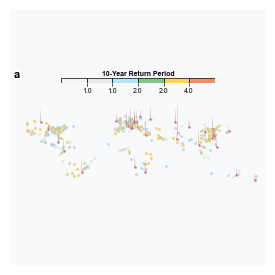

3D密度图生成完成！


In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import art3d
from matplotlib.colors import to_rgba

def plot_3d_density(
    df_weight, 
    world_shp,
    base_shp=None,
    var_names=('10yr'),
    var_threshold_pcts=(5),
    *, 
    spike_mode='line'        # 'line' | 'cone' | 'pyramid'
):
    """
    目标：
    - def _stretch_xy 函数控制的是图像伸缩程度（需要大量实验测试，不同的底图有不同伸缩方式来适应）
    - def _fullwidth_axe函数控制的是数据框大小（相当于地图外侧有个数据框，它与画布的设置figsize是有所不同的）
    - 主要控制视觉效果的是CFG中的elev，azim；
    - 峰值（我这里给出了三种）
    """

    CFG = dict(
        fig_size=(65/25.4, 30/25.4),
        elev=60, azim=-90,        # ≈30°俯视、另外一个控制朝向，一般来说从南看北是这个角度。
        bg="#f7f9fb",
        border_frac=0.01,         # 地图四周小留白
        z_exag=0.75,               # 控制峰值的大小
        peak_floor=0.25,
        max_spikes=300,
        line_width=1.0,
        cmaps=(plt.cm.Blues, plt.cm.YlOrBr, plt.cm.Oranges, plt.cm.Reds),
        # 修改分位数配置，让峰值阈值与最后一个颜色条值对齐
        colorbar_percentiles=[90, 70, 50, 30, 10],  # 对应10%, 30%, 50%, 70%, 90%分位数
        simplify_factor=0.1,
        max_base_features=800, # 简化因子       # 最大特征数
        base_simplify_factor=0.05,  # 底图简化因子
    )

    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "axes.linewidth": 0.5, "axes.edgecolor": "black",
    })

    # ——— 数据准备（使用city字段关联） ———
    
    # 通过city字段进行关联
    joined = world_shp.merge(
        df_weight[['city'] + list(var_names)], 
        on='city', 
        how='inner'
    )
    
    # 计算统计值（按city分组）
    stats = joined.groupby('city').agg({vn: "mean" for vn in var_names}).reset_index()
    world_plot = world_shp.merge(stats, on='city', how='left').fillna(0.0)
    if base_shp is not None:
        base_plot = base_shp.simplify(CFG["base_simplify_factor"])
        if len(base_plot) > CFG["max_base_features"]:
            base_plot['area'] = base_plot.geometry.area
            base_plot = base_plot.nlargest(CFG["max_base_features"], 'area').drop(columns=['area'])
   
    # 获取边界框
    xmin0, ymin0, xmax0, ymax0 = world_plot.total_bounds
    bx = (xmax0 - xmin0) * CFG["border_frac"]
    by = (ymax0 - ymin0) * CFG["border_frac"]
    xmin, xmax = xmin0 - bx, xmax0 + bx
    ymin, ymax = ymin0 - by, ymax0 + by
    xmid, ymid = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    xspan, yspan = (xmax-xmin), (ymax-ymin)

    figs = []

    # —— 关键：自动把 3D pane 变成"以宽度为限的正方形"，并贴到底边 —— 
    def _fullwidth_axes(fig, ax):
        fw, fh = fig.get_size_inches()         # 例如 60mm×35mm
        need_h_norm = (fw / fh)                # 让轴域的归一化高度 >= 宽度（1.0）* (fw/fh)
        h = need_h_norm * 1.02              # 略加 2% 缓冲
        bottom = 1.5 - h                       # 顶边对齐到 1.0，把轴域整体"向下拉出画布"
        ax.set_position([0.0, bottom, 1.0, h]) # → pane 会以"宽度"为限制，横向吃满 60mm

    def _stretch_xy(fig, y_scale=1.0):
        # x和y都可拉伸，y_scale控制y方向拉伸倍数（默认1.0为不变）
        fw, fh = fig.get_size_inches()
        target_aspect = fw / fh
        data_aspect   = (xspan / yspan) if yspan > 0 else 1.0
        sx = target_aspect / data_aspect
        sy = y_scale * 1.25
        def sx_fun(xx): return xmid + sx*(xx - xmid)
        def sy_fun(yy): return ymid + sy*(yy - ymid)
        return sx_fun, sy_fun, sx, sy

    # ——— 可选的体块峰（若需要） ———
    def _add_line(ax, cx, cy, H, color, lw):
        ax.plot([cx,cx],[cy,cy],[0,H], color=color, lw=lw, alpha=0.95, zorder=20)

    def _add_cone(ax, cx, cy, H, color):
        # 极简圆锥：两圈就够（轻量）
        th = np.linspace(0, 2*np.pi, 24, endpoint=False)
        r0, r1 = 0.12, 0.0
        x0, y0 = cx + r0*np.cos(th), cy + r0*np.sin(th)
        x1, y1 = cx + r1*np.cos(th), cy + r1*np.sin(th)
        faces=[]
        for j in range(len(th)):
            j2=(j+1)%len(th)
            faces.append([(x0[j],y0[j],0.0),(x0[j2],y0[j2],0.0),(x1[j2],y1[j2],H)])
            faces.append([(x0[j],y0[j],0.0),(x1[j2],y1[j2],H), (x1[j],y1[j],H)])
        ax.add_collection3d(
            Poly3DCollection(
                faces,
                facecolor = (color if (isinstance(color, (tuple, list)) and len(color) in (3,4))
                            else to_rgba(color, alpha=0.96)),
                edgecolor=None, linewidths=0.1
            )
        )

    def _add_pyramid(ax, cx, cy, H, color):
        d = 0.1
        base = np.array([[cx-d,cy,0],[cx,cy+d,0],[cx+d,cy,0],[cx,cy-d,0]])
        apex = np.array([cx,cy,H])
        faces=[[base[0],base[1],apex],[base[1],base[2],apex],[base[2],base[3],apex],[base[3],base[0],apex]]
        ax.add_collection3d(
            Poly3DCollection(
                faces,
                facecolor = (color if (isinstance(color, (tuple, list)) and len(color) in (3,4))
                            else to_rgba(color, alpha=0.96)),
                edgecolor=None, linewidths=0.12
            )
        )

    # 定义6种不同的颜色 - 统一使用相同的颜色定义
    discrete_colors = [
        '#E8E8E8',  # 第1段：浅灰色 (最低值)
        '#B3E5FC',  # 第2段：浅蓝色
        '#81C784',  # 第3段：浅绿色
        '#FFD54F',  # 第4段：浅黄色
        '#FF8A65',  # 第5段：浅橙色
        '#E57373'   # 第6段：浅红色 (最高值)
    ]

    def _add_colorbar(fig, ax, colorbar_thresholds, cmap, variable_name, peak_threshold, discrete_colors):
        """添加左下角6段colorbar，在颜色交界处显示原始数值"""
        left, bottom, width, height = 0.20, 0.85, 0.60, 0.045
        cax = fig.add_axes([left, bottom, width, height], zorder=100)
        cax.set_in_layout(False)
        cax.set_zorder(50)

        # 6段颜色：使用统一的离散颜色定义
        colors = ['whitesmoke']  # 第一段：灰色
        colors.extend(discrete_colors)  # 添加5段离散颜色
        
        # 绘制colorbar
        segment_width = 1.0 / 6
        for i in range(6):
            x_start = i * segment_width
            x_end = (i + 1) * segment_width
            cax.barh(0.5, x_end - x_start, left=x_start, height=1,
                    color=colors[i], edgecolor='black', linewidth=0.5)

        # 设置范围
        cax.set_xlim(0, 1)
        cax.set_ylim(0, 1)
        cax.set_yticks([])
        for spine in cax.spines.values():
            spine.set_visible(False)
        
        # 在颜色交界处显示原始数值
        tick_positions = [i * segment_width for i in range(1, 6)]  # 5个交界处位置
        tick_values = colorbar_thresholds  # 5个阈值
        tick_labels = [f'{v:.1f}' for v in tick_values]  # 保留1位小数
        
        cax.set_xticks(tick_positions)
        cax.set_xticklabels(tick_labels, fontsize=5)
        
        # 缩小tick大小
        cax.tick_params(axis='x', which='major', length=2, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1, width=0.3, label1On=False)
        
        # 添加标题
        cax.text(0.5, 1.3, variable_name, ha='center', va='bottom', 
                fontsize=5, fontweight='bold', transform=cax.transAxes)

        return cax

    def get_color_for_value(v, colorbar_thresholds, discrete_colors, peak_threshold):
        """根据数值返回对应的颜色，确保与颜色条完全一致"""
        if v <= 0:
            return 'whitesmoke'
        
        # 将阈值从低到高排序
        thresholds = sorted(colorbar_thresholds)
        
        # 找到数值对应的区间
        for i, threshold in enumerate(thresholds):
            if v < threshold:
                if i == 0:
                    return 'whitesmoke'  # 小于第一个阈值
                else:
                    return discrete_colors[i-1]  # 使用对应的离散颜色
        
        # 关键修改：只有超过峰值阈值的点才使用最高颜色（红色）
        if v >= peak_threshold:
            return discrete_colors[-1]  # 使用最深的颜色（红色）
        else:
            # 超过颜色条最高阈值但未达到峰值阈值的点，使用次高颜色
            return discrete_colors[-2]  # 使用橙色

    for i,(vn,pctl) in enumerate(zip(var_names, var_threshold_pcts)):
        cmap = CFG["cmaps"][i] if i < len(CFG["cmaps"]) else plt.cm.viridis

        fig = plt.figure(figsize=CFG["fig_size"])
        ax  = fig.add_subplot(111, projection="3d")
        ax.set_axis_off()
        fig.patch.set_facecolor("white")
        ax.set_facecolor(CFG["bg"])

        # —— 横向拉伸（x 变宽，y 不变）——
        sx_fun, sy_fun, sx, sy = _stretch_xy(fig)
        xmin_s, xmax_s = sx_fun(xmin), sx_fun(xmax)
        ymin_s, ymax_s = sy_fun(ymin), sy_fun(ymax)
        xspan_s, yspan_s = (xmax_s-xmin_s), (ymax_s-ymin_s)
        z_target = CFG["z_exag"] * max(xspan_s, yspan_s)

        # —— 先设置范围 —— 
        ax.set_xlim(xmin_s, xmax_s)
        ax.set_ylim(ymin_s, ymax_s)
        ax.set_zlim(0, z_target)

        try: ax.set_proj_type('ortho')
        except Exception: pass
        ax.view_init(elev=CFG["elev"], azim=CFG["azim"])

        # —— 把 pane 做"又宽又扁"，但关键靠下面的 _fullwidth_axes —— 
        try: ax.set_box_aspect([xspan_s*1.8, yspan_s, z_target*0.6])
        except Exception: pass

        # —— 彻底让 pane 以"宽度"为限制，并贴到底边 —— 
        _fullwidth_axes(fig, ax)   
        for f in (ax.set_zmargin, ax.set_xmargin, ax.set_ymargin):
            try: f(0.0)
            except Exception: pass

        if base_shp is not None:
            for geom in base_plot.geometry:
                if geom.is_empty: continue
                geoms = [geom] if geom.geom_type=="Polygon" else list(geom.geoms)
                for g in geoms:
                    x, y = g.exterior.xy
                    ax.plot(sx_fun(np.asarray(x)), sy_fun(np.asarray(y)), 
                        np.full_like(x, 0), 
                        color="lightgray", lw=0.1, alpha=0.5, zorder=1)

        # 绘制点数据（Z=0）
        for geom in world_plot.geometry:
            if geom.is_empty: continue
            x, y = geom.x, geom.y
            xs, ys = sx_fun(x), sy_fun(y)
            ax.scatter(xs, ys, 0, color='gray', s=1, alpha=0.3, zorder=1)

        # 底图
        vals_all = world_plot[vn].to_numpy(float)
        pos_all  = vals_all[vals_all > 0]

        if pos_all.size == 0:
            thr = 0.0
            colorbar_thresholds = [0.0]*5
        else:
            # 计算峰值阈值：var_threshold_pcts=[10] 表示90%分位数
            thr = np.percentile(pos_all, 100-pctl)
            # 计算颜色条阈值：colorbar_percentiles=[90, 70, 50, 30, 10] 对应10%, 30%, 50%, 70%, 90%分位数
            colorbar_thresholds = [np.percentile(pos_all, 100-p) for p in CFG["colorbar_percentiles"]]
            
            # 确保最后一个阈值与峰值阈值完全一致
            colorbar_thresholds[-1] = thr

        # 绘制带颜色的点 - 使用离散颜色
        for _, row in world_plot.iterrows():
            geom = row.geometry
            v    = float(row[vn])
            
            # 使用离散颜色映射，传入峰值阈值
            color = get_color_for_value(v, colorbar_thresholds, discrete_colors, thr)
            
            # 绘制带颜色的点
            if geom.geom_type == "Point":
                x, y = geom.x, geom.y
                xs, ys = sx_fun(x), sy_fun(y)
                ax.scatter(xs, ys, 0, color=color, s=0.5, alpha=0.9, zorder=10)

        # 峰（默认线段，最简单）
        needles = world_plot[world_plot[vn] >= thr].copy()
        needles = needles.sort_values(vn, ascending=False).head(CFG["max_spikes"])
        Hmin = CFG["peak_floor"] * z_target
        vmax = max(thr, needles[vn].max()) if not needles.empty else thr
        for _, row in needles.iterrows():
            v = float(row[vn]); s = 0 if vmax<=0 else (v - thr) / (vmax - thr + 1e-9)
            H = Hmin + (z_target - Hmin) * (s * 0.7)
            c  = row.geometry.centroid
            cx, cy = sx_fun(c.x), sy_fun(c.y)
            # 峰值使用最高颜色（红色）
            col = discrete_colors[-1]
            if spike_mode == 'line':
                ax.plot([cx,cx],[cy,cy],[0,H], color=col, lw=CFG["line_width"], alpha=0.95, zorder=20)
            elif spike_mode == 'cone':
                _add_cone(ax, cx, cy, H, col)
            elif spike_mode == 'pyramid':
                _add_pyramid(ax, cx, cy, H, col)

        # 面板字母
        fig.text(0.015, 0.97, chr(ord('a')+i), ha='left', va='top',
                 fontsize=8, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.85, pad=0.25, lw=0))

        # 使用默认标题或传入的标题
        title = f"Variable {i+1}" if 'titles' not in globals() else titles[i]
        cax_colorbar = _add_colorbar(fig, ax, colorbar_thresholds, cmap, title, thr, discrete_colors)

        figs.append(fig)

    return figs

# ==================== 主程序 ====================
try:
    # 先定义titles变量
    titles = ['10-Year Return Period']
    
    figs = plot_3d_density(
        df_weight, world_shp, base_shp=None,   # 使用world_shp
        var_names=['10yr'],
        var_threshold_pcts=[10],
        spike_mode='cone'  # 或 'cone' / 'pyramid'
    )

    # 保存图片
    import os

    # 创建目录（如果不存在）
    output_dir = "figure"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, fig in enumerate(figs):
        filename_png = os.path.join(output_dir, f"3d_density_{titles[i].lower()}_300dpi.png")
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()

        plt.show()
        plt.close(fig)
    
    print("3D密度图生成完成！")

except Exception as e:
    print(f"生成3D密度图时出错: {e}")